<a href="https://colab.research.google.com/github/Northwind01/metaphors/blob/master/3_CBOW_slow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# CBOW

https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html

https://medium.com/@TalPerry/getting-text-into-tensorflow-with-the-dataset-api-ffb832c8bec6

## 0. Set-up

### Imports

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
import os
import numpy as np
import _pickle as cPickle

### Get Google drive access

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Set the paths

In [0]:
root_path = 'gdrive/My Drive/metaphors/'
corpus_dir = root_path + 'data/Wikipedia/'
pickle_dir = root_path + 'data/pickles/'
CBOW_dir = root_path + 'models/CBOW/'

## 1. Build the corpus vocabulary

In [0]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Get the corpus

In [0]:
corpus_text_file = os.path.join(corpus_dir, 'wiki_en.txt')
corpus_file = open(corpus_text_file,'r')
corpus = corpus_file.read()
len(corpus)

327728373

In [0]:
sents = sent_tokenize(corpus)

In [0]:
sents[4][2]

' '

### Build corpus vocabulary

In [0]:
path = os.path.join(pickle_dir + 'CBOW/', 'tokenizer.pickle')

#### First time

In [0]:
%%time
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(sents)

CPU times: user 57.3 s, sys: 66.4 ms, total: 57.4 s
Wall time: 57.3 s


In [0]:
%%time
word2id = tokenizer.word_index
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(sent)] for sent in sents]

CPU times: user 38.6 s, sys: 312 ms, total: 38.9 s
Wall time: 38.9 s


In [0]:
with open(path, "wb") as output_file:
  cPickle.dump(tokenizer, output_file)
  cPickle.dump(word2id, output_file)
  cPickle.dump(id2word, output_file)
  cPickle.dump(wids, output_file)

#### Unpickle vocabulary

In [0]:
with open(path, "rb") as input_file:
  tokenizer = cPickle.load(input_file)
  word2id = cPickle.load(input_file)
  id2word = cPickle.load(input_file)
  wids = cPickle.load(input_file)

#### Define CBOW parameters

In [0]:
vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary size:', vocab_size)
print('Vocabulary sample:', list(word2id.items())[:10])

Vocabulary size: 859144
Vocabulary sample: [('the', 1), ('of', 2), ('and', 3), ('in', 4), ('to', 5), ('a', 6), ('is', 7), ('as', 8), ('was', 9), ('for', 10)]


## 2. Build a CBOW (context, target) generator

In [0]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
  context_length = window_size*2
  for words in corpus:
    sentence_length = len(words)
    for index, word in enumerate(words):
      context_words = []
      label_word   = []            
      start = index - window_size
      end = index + window_size + 1
            
      context_words.append([words[i] 
                            for i in range(start, end) 
                            if 0 <= i < sentence_length 
                            and i != index])
      label_word.append(word)

      x = sequence.pad_sequences(context_words, maxlen=context_length)
      y = to_categorical(label_word, vocab_size)
      yield (x, y)

In [0]:
# Just checking
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ["'''anarchism'''", 'is', 'political', 'and'] -> Target (Y): an
Context (X): ['is', 'an', 'and', 'social'] -> Target (Y): political
Context (X): ['an', 'political', 'social', 'philosophy'] -> Target (Y): and
Context (X): ['political', 'and', 'philosophy', 'that'] -> Target (Y): social
Context (X): ['and', 'social', 'that', 'rejects'] -> Target (Y): philosophy
Context (X): ['social', 'philosophy', 'rejects', 'hierarchies'] -> Target (Y): that
Context (X): ['philosophy', 'that', 'hierarchies', 'deemed'] -> Target (Y): rejects
Context (X): ['that', 'rejects', 'deemed', 'unjust'] -> Target (Y): hierarchies
Context (X): ['rejects', 'hierarchies', 'unjust', 'and'] -> Target (Y): deemed
Context (X): ['hierarchies', 'deemed', 'and', 'advocates'] -> Target (Y): unjust
Context (X): ['deemed', 'unjust', 'advocates', 'their'] -> Target (Y): and


## 3. Build the CBOW model architecture

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda

In [0]:
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# View model summary
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            85914400  
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 859144)            86773544  
Total params: 172,687,944
Trainable params: 172,687,944
Non-trainable params: 0
_________________________________________________________________
None


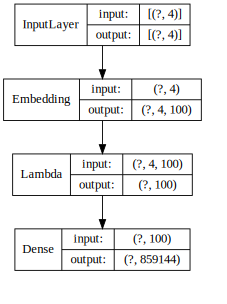

In [0]:
# Visualize model structure
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, dpi=65,
                 rankdir='TB').create(prog='dot', format='svg'))

## 4. Train the model

In [0]:
for epoch in range(1, 6):
  loss = 0.
  i = 0
  for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    i += 1
    loss += cbow.train_on_batch(x, y)
    if i % 10000 == 0:
      print('Processed {} (context, word) pairs'.format(i))

  print('Epoch:', epoch, '\tLoss:', loss)
  print()

Processed 10000 (context, word) pairs
Processed 20000 (context, word) pairs
Processed 30000 (context, word) pairs
Processed 40000 (context, word) pairs


KeyboardInterrupt: ignored

In [0]:
tf.keras.models.save_model(
    cbow,
    CBOW_dir+'model',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gdrive/My Drive/metaphors/models/CBOW/model/assets


## 5. Get word embeddings

In [0]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words